# dmm2-for-asc

In [1]:
%matplotlib inline 

import sys
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import math
import json
import glob

tag='00000Results'
token=''

In [6]:
import stattools as st

# Burstiness

In [3]:
cm = st.read_idxs('00103MakeData.out/fold01/*.NodeFRT.idx')

> Reading 00103MakeData.out/fold01/fold01.NodeFRT.idx...
< Read 204 lines and found the maximum index 1669
> Reading 00103MakeData.out/fold01/fold02.NodeFRT.idx...
< Read 209 lines and found the maximum index 1692
> Reading 00103MakeData.out/fold01/fold03.NodeFRT.idx...
< Read 206 lines and found the maximum index 1698
> Reading 00103MakeData.out/fold01/fold04.NodeFRT.idx...
< Read 209 lines and found the maximum index 1698
> Reading 00103MakeData.out/fold01/fold05.NodeFRT.idx...
< Read 205 lines and found the maximum index 1697
> Reading 00103MakeData.out/fold01/fold06.NodeFRT.idx...
< Read 209 lines and found the maximum index 1698
> Reading 00103MakeData.out/fold01/fold07.NodeFRT.idx...
< Read 206 lines and found the maximum index 1698
> Reading 00103MakeData.out/fold01/fold08.NodeFRT.idx...
< Read 211 lines and found the maximum index 1698
> Reading 00103MakeData.out/fold01/fold09.NodeFRT.idx...
< Read 205 lines and found the maximum index 1698
> Reading 00103MakeData.out/fold01/fo

In [9]:
def show_freqprob_average(d2w, topi, xlim=None, figsize=(8,5)):
    print(d2w.shape)
    wfreq = np.sum(d2w, axis=0)
    print(wfreq.shape)
    idxs = np.argsort(wfreq)
    idxs_sorted_descending_order = idxs[::-1]
    wfreq_sorted_descending_order = wfreq[idxs_sorted_descending_order]
    avg = np.mean(wfreq_sorted_descending_order)
    avgi = 0
    for i in range(len(wfreq_sorted_descending_order)):
        if wfreq_sorted_descending_order[i] < avg:
            avgi = i
            break
    avgr = avgi + avgi - topi
    plt.plot(list(range(len(wfreq_sorted_descending_order))), wfreq_sorted_descending_order)
    plt.plot([0, len(wfreq_sorted_descending_order)], [wfreq_sorted_descending_order[topi], wfreq_sorted_descending_order[topi]])
    plt.plot([topi], [wfreq_sorted_descending_order[topi]], marker='+')
    plt.text(topi, wfreq_sorted_descending_order[topi], '(%d, %d)' % (topi, wfreq_sorted_descending_order[topi]), ha='left', va='bottom')
    plt.text(len(wfreq_sorted_descending_order), wfreq_sorted_descending_order[topi], '%.3f' % wfreq_sorted_descending_order[topi], ha='right', va='bottom')
    plt.plot([0, len(wfreq_sorted_descending_order)], [avg, avg])
    plt.plot([avgi], [wfreq_sorted_descending_order[avgi]], marker='*')
    plt.text(avgi, wfreq_sorted_descending_order[avgi], '(%d, %d)' % (avgi, wfreq_sorted_descending_order[avgi]), ha='left', va='bottom')
    plt.text(len(wfreq_sorted_descending_order), avg, '%.3f' % avg, ha='right', va='bottom')
    plt.plot([avgr], [wfreq_sorted_descending_order[avgr]], marker='+')
    plt.text(avgr, wfreq_sorted_descending_order[avgr], '(%d, %d)' % (avgr, wfreq_sorted_descending_order[avgr]), ha='left', va='bottom')
    plt.show()

    wfreq_top = idxs_sorted_descending_order[0:topi]
    wfreq_average = idxs_sorted_descending_order[topi:avgr+1]
    wfreq_rare = idxs_sorted_descending_order[avgr+1:]
    print('top%u=%u, average[%u,%u]=%u, rare=%u' % (topi, len(wfreq_top), topi, avgr, len(wfreq_average), len(wfreq_rare)))
    prob_top = st.collect_probs(d2w, wfreq_top)
    avrg_top = st.comp_average(prob_top)
    prob_average = st.collect_probs(d2w, wfreq_average)
    avrg_average = st.comp_average(prob_average)
    prob_rare = st.collect_probs(d2w, wfreq_rare)
    avrg_rare = st.comp_average(prob_rare)

    fig = plt.figure(figsize=figsize, layout='constrained')
    st.plot_count(['top%u'%(len(wfreq_top)), 'average%u'%(len(wfreq_average)), 'rare%u'%(len(wfreq_rare))], [avrg_top, avrg_average, avrg_rare], '', xlim=xlim)
    #plt.tight_layout()
    plt.legend()
    return fig

(13531, 1699)
(1699,)


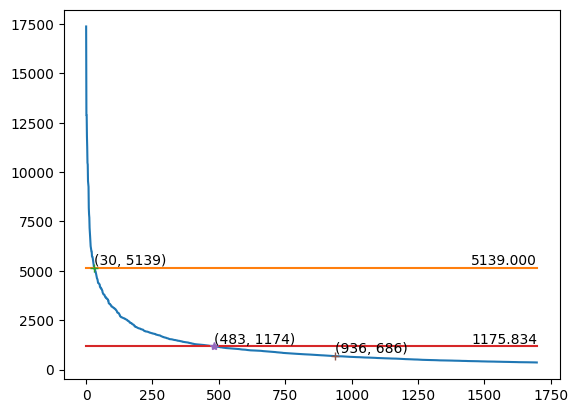

top30=30, average[30,936]=907, rare=762


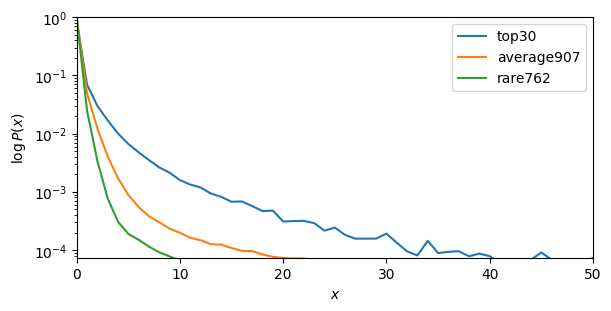

In [10]:
fig = show_freqprob_average(cm, 30, xlim=(0,50), figsize=(6,3))
plt.xlabel('$x$')
plt.ylabel('$\log P(x)$')
plt.show()

In [102]:
fig.savefig('burstiness_30_907_762_01003FRT.svg', format="svg")
fig.savefig('burstiness_30_907_762_01003FRT.eps', format="eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# Encodec

In [11]:
def show_scores(data, titles, metrics=['accuracy', 'accuracy_std', 'F1', 'F1_std'], mstr=['ACC', 'ACCstd', 'F1', 'F1std'], ks=None):
    for i in range(len(data)):
        t = titles[i]
        print('%s' % t)
        print('K\t', end='')
        for j in range(len(mstr)):
            print('%s\t' % mstr[j], end='')
        print('')
        if ks is None:
            ks = data[i]['K']
        for k in range(len(ks)):
            print('%03u\t' % (ks[k]), end='')
            for m in metrics:
                print('%.3f\t' % (data[i][m][k]), end='')
            print('')
metrics = ['accuracy', 'accuracy_std', 'F1', 'F1_std']

## Ensembling three streams

### large labeled data setting $E_1 V_1 T_{62}$

In [12]:
#E1V1T62 Ensembling three streams
N1enc_msds3_nemb_shuffle_Ens_cv64eqlE1V1Tx = st.read_results('0B206Eval_encodec.loocvE1V1Tx.Ensemble.x.out.stat.txt')
N2enc_msds3_nemb_shuffle_Ens_cv64eqlE1V1Tx = st.read_results('0B216Eval_encodec.loocvE1V1Tx.Ensemble.x.out.stat.txt')
N3enc_msds3_nemb_shuffle_Ens_cv64eqlE1V1Tx = st.read_results('0B226Eval_encodec.loocvE1V1Tx.Ensemble.x.out.stat.txt')
N4enc_msds3_nemb_shuffle_Ens_cv64eqlE1V1Tx = st.read_results('0B236Eval_encodec.loocvE1V1Tx.Ensemble.x.out.stat.txt')

In [13]:
data = [N1enc_msds3_nemb_shuffle_Ens_cv64eqlE1V1Tx, 
        N2enc_msds3_nemb_shuffle_Ens_cv64eqlE1V1Tx,
        N3enc_msds3_nemb_shuffle_Ens_cv64eqlE1V1Tx, 
        N4enc_msds3_nemb_shuffle_Ens_cv64eqlE1V1Tx]
show_scores(data, ['Node1 E1V1T62', 'Node2 E1V1T62', 'Node3 E1V1T62', 'Node4 E1V1T62'], ks=[0])

Node1 E1V1T62
K	ACC	ACCstd	F1	F1std	
000	0.949	0.016	0.876	0.038	
Node2 E1V1T62
K	ACC	ACCstd	F1	F1std	
000	0.957	0.015	0.900	0.037	
Node3 E1V1T62
K	ACC	ACCstd	F1	F1std	
000	0.956	0.014	0.894	0.033	
Node4 E1V1T62
K	ACC	ACCstd	F1	F1std	
000	0.949	0.017	0.875	0.042	


### small labeled data setting $T_1 V_1 E_{62}$

In [14]:
#T1V1E62 Ensembling three streams
N1enc_msds3_nemb_shuffle_Ens_cv64eqlT1V1Ex = st.read_results('0B106Eval_encodec.loocvT1V1Ex.Ensemble.x.out.stat.txt')
N2enc_msds3_nemb_shuffle_Ens_cv64eqlT1V1Ex = st.read_results('0B116Eval_encodec.loocvT1V1Ex.Ensemble.x.out.stat.txt')
N3enc_msds3_nemb_shuffle_Ens_cv64eqlT1V1Ex = st.read_results('0B126Eval_encodec.loocvT1V1Ex.Ensemble.x.out.stat.txt')
N4enc_msds3_nemb_shuffle_Ens_cv64eqlT1V1Ex = st.read_results('0B136Eval_encodec.loocvT1V1Ex.Ensemble.x.out.stat.txt')

In [15]:
data = [N1enc_msds3_nemb_shuffle_Ens_cv64eqlT1V1Ex, 
        N2enc_msds3_nemb_shuffle_Ens_cv64eqlT1V1Ex,
        N3enc_msds3_nemb_shuffle_Ens_cv64eqlT1V1Ex, 
        N4enc_msds3_nemb_shuffle_Ens_cv64eqlT1V1Ex]
show_scores(data, ['Node1 T1V1E62', 'Node2 T1V1E62', 'Node3 T1V1E62', 'Node4 T1V1E62'], ks=[0])

Node1 T1V1E62
K	ACC	ACCstd	F1	F1std	
000	0.849	0.044	0.663	0.112	
Node2 T1V1E62
K	ACC	ACCstd	F1	F1std	
000	0.865	0.028	0.705	0.064	
Node3 T1V1E62
K	ACC	ACCstd	F1	F1std	
000	0.871	0.013	0.705	0.031	
Node4 T1V1E62
K	ACC	ACCstd	F1	F1std	
000	0.848	0.039	0.683	0.034	


## Using a single stream

In [16]:
# E1V1Tx stream FRT
N1enc_msds3_nemb_shuffle_FRT_cv64eqlE1V1Tx = st.read_results('0B206Eval_encodec.loocvE1V1Tx.Node1FRT.x.out.stat.txt')
N2enc_msds3_nemb_shuffle_FRT_cv64eqlE1V1Tx = st.read_results('0B216Eval_encodec.loocvE1V1Tx.Node2FRT.x.out.stat.txt')
N3enc_msds3_nemb_shuffle_FRT_cv64eqlE1V1Tx = st.read_results('0B226Eval_encodec.loocvE1V1Tx.Node3FRT.x.out.stat.txt')
N4enc_msds3_nemb_shuffle_FRT_cv64eqlE1V1Tx = st.read_results('0B236Eval_encodec.loocvE1V1Tx.Node4FRT.x.out.stat.txt')

In [17]:
data = [N1enc_msds3_nemb_shuffle_FRT_cv64eqlE1V1Tx, 
        N2enc_msds3_nemb_shuffle_FRT_cv64eqlE1V1Tx,
        N3enc_msds3_nemb_shuffle_FRT_cv64eqlE1V1Tx, 
        N4enc_msds3_nemb_shuffle_FRT_cv64eqlE1V1Tx]
show_scores(data, ['Node1 E1V1T62', 'Node2 E1V1T62', 'Node3 E1V1T62', 'Node4 E1V1T62'], ks=[0])

Node1 E1V1T62
K	ACC	ACCstd	F1	F1std	
000	0.934	0.020	0.845	0.048	
Node2 E1V1T62
K	ACC	ACCstd	F1	F1std	
000	0.950	0.022	0.882	0.050	
Node3 E1V1T62
K	ACC	ACCstd	F1	F1std	
000	0.944	0.025	0.865	0.058	
Node4 E1V1T62
K	ACC	ACCstd	F1	F1std	
000	0.940	0.020	0.860	0.046	


# KMeans

## Using a single stream

In [18]:
N2enc_frt_nemb_shuffle_KM_cv64eqlT1V1ExM2 = st.read_results('0B322EvalKMeans_T1V1ExM2.x.out.stat.txt')
N2enc_frt_nemb_shuffle_KM_cv64eqlE1V1TxMx = st.read_results('0B323EvalKMeans_E1V1TxMx.x.out.stat.txt')

In [19]:
data = [N2enc_frt_nemb_shuffle_KM_cv64eqlT1V1ExM2, 
        N2enc_frt_nemb_shuffle_KM_cv64eqlE1V1TxMx]
show_scores(data, ['KMeans T1V1E62 M2', 'KMeans E1V1T62 M63'])

KMeans T1V1E62 M2
K	ACC	ACCstd	F1	F1std	
008	0.739	0.029	0.449	0.025	
009	0.771	0.028	0.484	0.033	
010	0.757	0.021	0.477	0.021	
020	0.783	0.016	0.529	0.031	
030	0.808	0.025	0.582	0.025	
040	0.799	0.030	0.578	0.026	
050	0.782	0.033	0.559	0.026	
060	0.771	0.037	0.561	0.030	
070	0.765	0.035	0.581	0.034	
100	0.737	0.033	0.559	0.035	
200	0.657	0.033	0.514	0.026	
400	0.534	0.031	0.444	0.025	
600	0.473	0.028	0.401	0.025	
KMeans E1V1T62 M63
K	ACC	ACCstd	F1	F1std	
008	0.764	0.019	0.432	0.011	
009	0.794	0.018	0.490	0.027	
010	0.772	0.019	0.461	0.021	
020	0.816	0.028	0.577	0.057	
030	0.846	0.027	0.625	0.053	
040	0.849	0.028	0.623	0.055	
050	0.852	0.024	0.641	0.058	
060	0.861	0.025	0.653	0.058	
070	0.867	0.026	0.676	0.060	
100	0.873	0.024	0.687	0.052	
200	0.891	0.030	0.736	0.065	
400	0.899	0.024	0.756	0.052	
600	0.900	0.026	0.764	0.054	


## Using three streams

In [20]:
N2enc_3st_nemb_shuffle_KM_cv64eqlT1V1ExM2 = st.read_results('0B327EvalKMeans_T1V1ExM2.x.out.stat.txt')
N2enc_3st_nemb_shuffle_KM_cv64eqlE1V1TxMx = st.read_results('0B328EvalKMeans_E1V1TxMx.x.out.stat.txt')

In [21]:
data = [N2enc_3st_nemb_shuffle_KM_cv64eqlT1V1ExM2, 
        N2enc_3st_nemb_shuffle_KM_cv64eqlE1V1TxMx]
show_scores(data, ['KMeans 3strm T1V1E62 M2', 'KMeans 3strm E1V1T62 M63'])

KMeans 3strm T1V1E62 M2
K	ACC	ACCstd	F1	F1std	
008	0.742	0.028	0.451	0.025	
009	0.772	0.031	0.490	0.030	
010	0.777	0.021	0.486	0.022	
011	0.775	0.023	0.488	0.028	
012	0.776	0.014	0.508	0.027	
013	0.789	0.018	0.510	0.030	
014	0.796	0.018	0.525	0.023	
015	0.782	0.021	0.522	0.036	
016	0.784	0.021	0.542	0.040	
017	0.791	0.022	0.533	0.027	
018	0.791	0.020	0.548	0.027	
019	0.794	0.015	0.533	0.025	
020	0.793	0.022	0.546	0.028	
021	0.784	0.020	0.534	0.033	
022	0.785	0.019	0.538	0.035	
023	0.798	0.019	0.552	0.030	
024	0.800	0.025	0.548	0.024	
025	0.786	0.017	0.535	0.029	
026	0.799	0.019	0.555	0.028	
027	0.793	0.016	0.540	0.024	
028	0.799	0.024	0.555	0.025	
029	0.795	0.026	0.559	0.028	
030	0.800	0.025	0.561	0.022	
031	0.802	0.028	0.569	0.026	
032	0.810	0.026	0.582	0.025	
033	0.803	0.029	0.560	0.026	
034	0.802	0.028	0.572	0.029	
035	0.804	0.028	0.563	0.024	
036	0.796	0.031	0.559	0.026	
037	0.799	0.031	0.560	0.026	
038	0.796	0.029	0.564	0.027	
039	0.804	0.025	0.580	0.023	
040	0.799	0.028	0.578	0.0

# Spectral Clusering
## Using all embedding vectors
- Using a single stream

In [22]:
N2enc_frt_nemb_shuffle_SCnn_cv64eqlT1V1ExM2 = st.read_results('0B382EvalSpectralClustering_T1V1ExM2.x.out.stat.txt')
N2enc_frt_nemb_shuffle_SCnn_cv64eqlE1V1TxMx = st.read_results('0B383EvalSpectralClustering_E1V1TxMx.x.out.stat.txt')

In [23]:
data = [N2enc_frt_nemb_shuffle_SCnn_cv64eqlT1V1ExM2, 
        N2enc_frt_nemb_shuffle_SCnn_cv64eqlE1V1TxMx]
show_scores(data, ['SpectralClustering, 1stream, AllFrames, T1V1E62 M2', 'Spectral Clustering, 1stream, AllFrames, E1V1T62 M63'])

SpectralClustering, 1stream, AllFrames, T1V1E62 M2
K	ACC	ACCstd	F1	F1std	
008	0.717	0.001	0.423	0.006	
009	0.693	0.005	0.397	0.024	
010	0.700	0.018	0.439	0.015	
020	0.706	0.024	0.434	0.026	
030	0.696	0.020	0.453	0.025	
040	0.691	0.024	0.466	0.031	
050	0.675	0.022	0.470	0.031	
060	0.679	0.025	0.470	0.033	
070	0.665	0.026	0.470	0.028	
100	0.641	0.024	0.445	0.028	
200	0.592	0.023	0.433	0.023	
400	0.512	0.025	0.387	0.019	
600	0.457	0.028	0.356	0.019	
Spectral Clustering, 1stream, AllFrames, E1V1T62 M63
K	ACC	ACCstd	F1	F1std	
008	0.717	0.020	0.421	0.026	
009	0.698	0.037	0.414	0.028	
010	0.715	0.037	0.427	0.024	
020	0.733	0.026	0.427	0.023	
030	0.727	0.026	0.460	0.033	
040	0.739	0.031	0.510	0.046	
050	0.737	0.029	0.509	0.044	
060	0.737	0.034	0.513	0.047	
070	0.736	0.025	0.514	0.046	
100	0.736	0.031	0.516	0.050	
200	0.745	0.026	0.540	0.045	
400	0.747	0.026	0.539	0.046	
600	0.751	0.028	0.542	0.050	


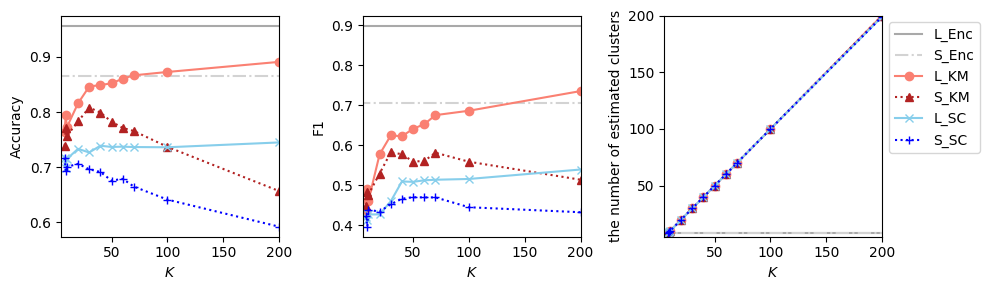

In [24]:
ks = [8,9,10,20,30,40,50,60,70,100,200]
data = [N2enc_msds3_nemb_shuffle_Ens_cv64eqlE1V1Tx,
        N2enc_msds3_nemb_shuffle_Ens_cv64eqlT1V1Ex,
        N2enc_frt_nemb_shuffle_KM_cv64eqlE1V1TxMx,
        N2enc_frt_nemb_shuffle_KM_cv64eqlT1V1ExM2,
        N2enc_frt_nemb_shuffle_SCnn_cv64eqlE1V1TxMx,
        N2enc_frt_nemb_shuffle_SCnn_cv64eqlT1V1ExM2]
labels = ['L_Enc', 'S_Enc', 'L_KM', 'S_KM', 'L_SC', 'S_SC']
colors = ['darkgray', 'lightgray', 'salmon', 'firebrick', 'skyblue', 'b']
markers = [None, None, 'o', '^', 'x', '+']
linestyles = ['-', '-.', '-', ':', '-', ':']
fig = plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
st.showone(data, 'accuracy', None, labels, None, None, colors=colors, markers=markers, linestyles=linestyles, xlim=(5,200), ylim=None, ks=ks)
plt.ylabel('Accuracy')
plt.xlabel('$K$')
plt.subplot(1,3,2)
st.showone(data, 'F1', None, labels, None, None, colors=colors, markers=markers, linestyles=linestyles, xlim=(5,200), ylim=None, ks=ks)
plt.ylabel('F1')
plt.xlabel('$K$')
plt.subplot(1,3,3)
st.showone(data, 'topics', None, labels, None, None, colors=colors, markers=markers, linestyles=linestyles, xlim=(5,200), ylim=(5,200), ks=ks)
plt.ylabel('the number of estimated clusters')
plt.xlabel('$K$')
plt.legend(frameon=True, bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [80]:
fig.savefig('KMeans_vs_SC.eps', format="eps")
fig.savefig('KMeans_vs_SC.svg', format="svg")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## Using feature vectors obtained by averaging embedding vectors of all frames for each audio segment
- using three streams
- affinity='nearest_neighbors'
- assign_labels='discretize'

In [25]:
N2enc_3st_nemb_shuffle_SCnn_cv64eqlT1V1ExM2 = st.read_results('0B342EvalSpectralClustering_T1V1ExM2.x.out.stat.txt')
N2enc_3st_nemb_shuffle_SCnn_cv64eqlE1V1TxMx = st.read_results('0B343EvalSpectralClustering_E1V1TxMx.x.out.stat.txt')

In [26]:
data = [N2enc_3st_nemb_shuffle_SCnn_cv64eqlT1V1ExM2, 
        N2enc_3st_nemb_shuffle_SCnn_cv64eqlE1V1TxMx]
show_scores(data, ['SpectralClustering, 3stream, avaraged, T1V1E62 M2', 'Spectral Clustering, 3stream, averaged, E1V1T62 M63'])

SpectralClustering, 3stream, avaraged, T1V1E62 M2
K	ACC	ACCstd	F1	F1std	
008	0.822	0.001	0.524	0.001	
009	0.817	0.010	0.522	0.023	
010	0.817	0.011	0.522	0.024	
011	0.819	0.011	0.538	0.024	
012	0.834	0.007	0.555	0.005	
013	0.834	0.007	0.554	0.008	
014	0.828	0.009	0.569	0.027	
015	0.834	0.009	0.560	0.021	
016	0.832	0.012	0.570	0.027	
017	0.832	0.016	0.583	0.023	
018	0.810	0.023	0.563	0.029	
019	0.814	0.017	0.575	0.032	
020	0.815	0.018	0.589	0.033	
021	0.804	0.025	0.563	0.033	
022	0.802	0.022	0.563	0.033	
023	0.808	0.016	0.597	0.049	
024	0.821	0.010	0.622	0.031	
025	0.826	0.011	0.645	0.037	
026	0.834	0.020	0.648	0.030	
027	0.821	0.029	0.642	0.038	
028	0.826	0.026	0.648	0.034	
029	0.824	0.026	0.653	0.035	
030	0.830	0.026	0.666	0.036	
031	0.831	0.025	0.666	0.035	
032	0.831	0.025	0.662	0.035	
033	0.826	0.027	0.663	0.035	
034	0.821	0.028	0.656	0.038	
035	0.821	0.029	0.660	0.036	
036	0.819	0.027	0.655	0.033	
037	0.817	0.027	0.654	0.033	
038	0.809	0.031	0.653	0.033	
039	0.817	0.029	0.656	0.035	

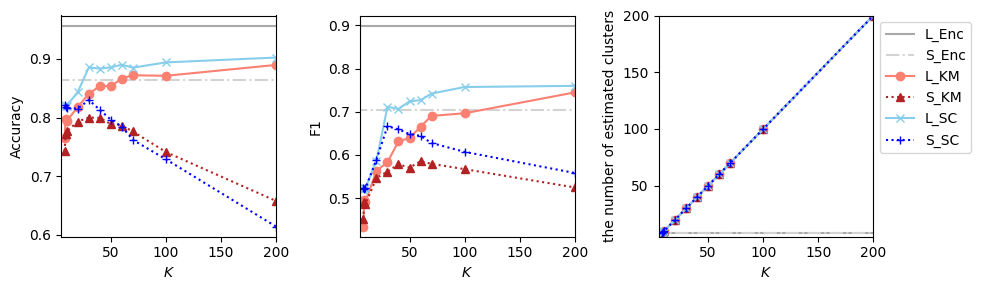

In [27]:
ks = [8,9,10,20,30,40,50,60,70,100,200]
data = [N2enc_msds3_nemb_shuffle_Ens_cv64eqlE1V1Tx,
        N2enc_msds3_nemb_shuffle_Ens_cv64eqlT1V1Ex,
        N2enc_3st_nemb_shuffle_KM_cv64eqlE1V1TxMx,
        N2enc_3st_nemb_shuffle_KM_cv64eqlT1V1ExM2,
        N2enc_3st_nemb_shuffle_SCnn_cv64eqlE1V1TxMx,
        N2enc_3st_nemb_shuffle_SCnn_cv64eqlT1V1ExM2]
labels = ['L_Enc', 'S_Enc', 'L_KM', 'S_KM', 'L_SC', 'S_SC']
colors = ['darkgray', 'lightgray', 'salmon', 'firebrick', 'skyblue', 'b']
markers = [None, None, 'o', '^', 'x', '+']
linestyles = ['-', '-.', '-', ':', '-', ':']
fig = plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
st.showone(data, 'accuracy', None, labels, None, None, colors=colors, markers=markers, linestyles=linestyles, xlim=(5,200), ylim=None,ks=ks)
plt.ylabel('Accuracy')
plt.xlabel('$K$')
plt.subplot(1,3,2)
st.showone(data, 'F1', None, labels, None, None, colors=colors, markers=markers, linestyles=linestyles, xlim=(5,200), ylim=None,ks=ks)
plt.ylabel('F1')
plt.xlabel('$K$')
plt.subplot(1,3,3)
st.showone(data, 'topics', None, labels, None, None, colors=colors, markers=markers, linestyles=linestyles, xlim=(5,200), ylim=(5,200),ks=ks)
plt.ylabel('the number of estimated clusters')
plt.xlabel('$K$')
plt.legend(frameon=True, bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [85]:
fig.savefig('KMeans_vs_SC_3streams.eps', format="eps")
fig.savefig('KMeans_vs_SC_3streams.svg', format="svg")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# DMM
## Using three streams

In [28]:
N2encT2_msds3_absFdfr10tfr060_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2 = st.read_results('01002EvalDMM2_epara_allseed_t1w1_T1V1ExM2.x.out.stat.txt') 
N2encT2_msds3_absFdfr10tfr060_clDMt1w1IB50allSeedOnly_cv64eqlE1V1TxMx = st.read_results('0100XEvalDMM2_epara_allseed_t1w1_E1V1TxMx.x.out.stat.txt') 

In [29]:
data = [N2encT2_msds3_absFdfr10tfr060_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2, 
        N2encT2_msds3_absFdfr10tfr060_clDMt1w1IB50allSeedOnly_cv64eqlE1V1TxMx]
show_scores(data, ['DMM, 3stream, TFR0.6, T1V1E62 M2', 'DMM, 3stream, TFR0.6, E1V1T62 M63'])

DMM, 3stream, TFR0.6, T1V1E62 M2
K	ACC	ACCstd	F1	F1std	
008	0.787	0.010	0.477	0.025	
009	0.787	0.010	0.475	0.024	
010	0.833	0.015	0.553	0.020	
011	0.832	0.021	0.553	0.013	
012	0.824	0.019	0.545	0.026	
013	0.849	0.012	0.570	0.016	
014	0.842	0.013	0.594	0.029	
015	0.816	0.030	0.542	0.026	
016	0.849	0.015	0.612	0.025	
017	0.843	0.022	0.569	0.017	
018	0.829	0.019	0.553	0.019	
019	0.841	0.019	0.585	0.027	
020	0.845	0.021	0.614	0.023	
021	0.845	0.021	0.617	0.031	
022	0.866	0.017	0.671	0.020	
023	0.853	0.020	0.631	0.023	
024	0.844	0.018	0.613	0.022	
025	0.873	0.019	0.718	0.017	
026	0.839	0.017	0.650	0.030	
027	0.861	0.018	0.667	0.020	
028	0.852	0.018	0.655	0.017	
029	0.866	0.019	0.687	0.027	
030	0.870	0.017	0.708	0.025	
031	0.862	0.018	0.669	0.021	
032	0.864	0.017	0.691	0.029	
033	0.868	0.017	0.716	0.018	
034	0.871	0.015	0.718	0.018	
035	0.850	0.017	0.645	0.021	
036	0.869	0.020	0.720	0.019	
037	0.867	0.020	0.717	0.019	
038	0.863	0.016	0.711	0.017	
039	0.867	0.016	0.718	0.018	
040	0.870	0.015	

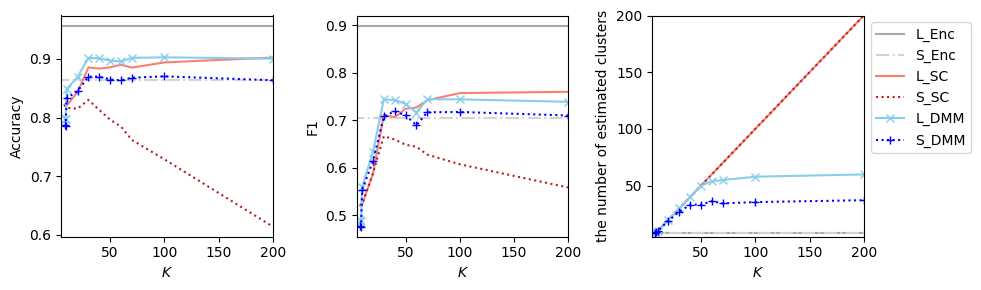

In [30]:
ks = [8,9,10,20,30,40,50,60,70,100,200]
data = [N2enc_msds3_nemb_shuffle_Ens_cv64eqlE1V1Tx,
        N2enc_msds3_nemb_shuffle_Ens_cv64eqlT1V1Ex,
        N2enc_3st_nemb_shuffle_SCnn_cv64eqlE1V1TxMx,
        N2enc_3st_nemb_shuffle_SCnn_cv64eqlT1V1ExM2,
        N2encT2_msds3_absFdfr10tfr060_clDMt1w1IB50allSeedOnly_cv64eqlE1V1TxMx,
        N2encT2_msds3_absFdfr10tfr060_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2]
#labels = ['Enc $E_1V_1T_{62}$', 'Enc $T_1V_1E_{62}$', 'KM  $E_1V_1T_{62}$', 'KM  $T_1V_1E_{62}$', 'DMM $E_1V_1T_{62}$', 'DMM $T_1V_1E_{62}$']
labels = ['L_Enc', 'S_Enc', 'L_SC', 'S_SC', 'L_DMM', 'S_DMM']
colors = ['darkgray', 'lightgray', 'salmon', 'firebrick', 'skyblue', 'b']
markers = [None, None, None, None, 'x', '+']
linestyles = ['-', '-.', '-', ':', '-', ':']
fig = plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
st.showone(data, 'accuracy', None, labels, None, None, colors=colors, markers=markers, linestyles=linestyles, xlim=(5,200), ylim=None, ks=ks)
plt.ylabel('Accuracy')
plt.xlabel('$K$')
plt.subplot(1,3,2)
st.showone(data, 'F1', None, labels, None, None, colors=colors, markers=markers, linestyles=linestyles, xlim=(5,200), ylim=None, ks=ks)
plt.ylabel('F1')
plt.xlabel('$K$')
plt.subplot(1,3,3)
st.showone(data, 'topics', None, labels, None, None, colors=colors, markers=markers, linestyles=linestyles, xlim=(5,200), ylim=(5,200), ks=ks)
plt.ylabel('the number of estimated clusters')
plt.xlabel('$K$')
plt.legend(frameon=True, bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [104]:
fig.savefig('DMMvsSC_rpdcbl.eps', format="eps")
fig.savefig('DMMcsSC_rpdcbl.svg', format="svg")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


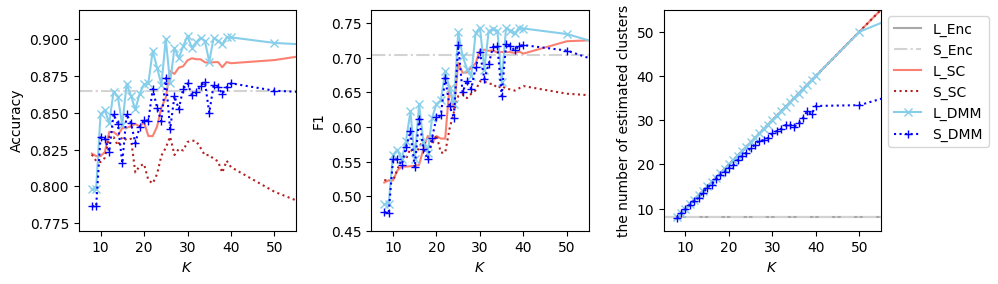

In [31]:
fig = plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
st.showone(data, 'accuracy', None, labels, None, None, colors=colors, markers=markers, linestyles=linestyles, xlim=(5,55), ylim=(0.77, 0.92))
plt.ylabel('Accuracy')
plt.xlabel('$K$')
plt.subplot(1,3,2)
st.showone(data, 'F1', None, labels, None, None, colors=colors, markers=markers, linestyles=linestyles, xlim=(5,55), ylim=(0.45,0.77))
plt.ylabel('F1')
plt.xlabel('$K$')
plt.subplot(1,3,3)
st.showone(data, 'topics', None, labels, None, None, colors=colors, markers=markers, linestyles=linestyles, xlim=(5,55), ylim=(5,55))
plt.ylabel('the number of estimated clusters')
plt.xlabel('$K$')
plt.legend(frameon=True, bbox_to_anchor=(1, 1), loc='upper left')
#plt.legend(frameon=False, bbox_to_anchor=(1, 0), loc='lower right')
plt.tight_layout()
plt.show()

In [91]:
fig.savefig('DMMvsSC_closeup_rpdcbl.eps', format="eps")
fig.savefig('DMMvsSC_closeup_rpdcbl.svg', format="svg")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## Using a single stream

In [32]:
N2encT2_FRT_absFdfr10tfr060_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2 = st.read_results('01102EvalDMM2_epara_allseed_t1w1_T1V1ExM2.x.out.stat.txt') 
N2encT2_FRT_absFdfr10tfr060_clDMt1w1IB50allSeedOnly_cv64eqlE1V1TxMx = st.read_results('0110XEvalDMM2_epara_allseed_t1w1_E1V1TxMx.x.out.stat.txt') 

### large labeled data settting $E_1 V_1 T_{62}$

In [33]:
data = [N2encT2_FRT_absFdfr10tfr060_clDMt1w1IB50allSeedOnly_cv64eqlE1V1TxMx]
show_scores(data, ['DMM, 1stream, TFR0.6, E1V1T62 M63'])

DMM, 1stream, TFR0.6, E1V1T62 M63
K	ACC	ACCstd	F1	F1std	
008	0.832	0.015	0.550	0.015	
009	0.832	0.015	0.550	0.015	
010	0.846	0.015	0.566	0.013	
011	0.859	0.013	0.576	0.013	
012	0.852	0.014	0.571	0.014	
013	0.859	0.013	0.577	0.014	
014	0.831	0.015	0.508	0.035	
015	0.860	0.013	0.577	0.014	
016	0.855	0.021	0.621	0.030	
017	0.855	0.021	0.620	0.030	
018	0.853	0.014	0.567	0.014	
019	0.864	0.013	0.627	0.027	
020	0.863	0.019	0.634	0.029	
021	0.858	0.013	0.576	0.013	
022	0.865	0.016	0.646	0.038	
023	0.852	0.015	0.552	0.026	
024	0.864	0.020	0.632	0.031	
025	0.857	0.013	0.571	0.013	
026	0.881	0.016	0.670	0.022	
027	0.878	0.017	0.664	0.024	
028	0.886	0.017	0.722	0.039	
029	0.888	0.018	0.723	0.038	
030	0.891	0.018	0.726	0.039	
031	0.891	0.018	0.727	0.039	
032	0.889	0.017	0.731	0.034	
033	0.890	0.019	0.727	0.037	
034	0.892	0.015	0.732	0.035	
035	0.891	0.017	0.731	0.036	
036	0.890	0.017	0.731	0.037	
037	0.886	0.019	0.719	0.037	
038	0.887	0.018	0.722	0.037	
039	0.891	0.016	0.731	0.036	
040	0.891	0.017

### small labeled data setting $T_1 V_1 E_{62}$

In [34]:
data = [N2encT2_FRT_absFdfr10tfr060_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2]
show_scores(data, ['DMM, 1stream, TFR0.6, T1V1E62 M2'])

DMM, 1stream, TFR0.6, T1V1E62 M2
K	ACC	ACCstd	F1	F1std	
008	0.810	0.029	0.535	0.017	
009	0.810	0.029	0.534	0.018	
010	0.827	0.022	0.552	0.010	
011	0.846	0.012	0.571	0.013	
012	0.834	0.018	0.564	0.014	
013	0.841	0.020	0.571	0.017	
014	0.803	0.018	0.494	0.014	
015	0.841	0.018	0.568	0.016	
016	0.826	0.022	0.586	0.031	
017	0.828	0.020	0.587	0.031	
018	0.822	0.027	0.556	0.015	
019	0.837	0.025	0.598	0.029	
020	0.829	0.022	0.601	0.032	
021	0.830	0.021	0.563	0.015	
022	0.830	0.022	0.619	0.019	
023	0.824	0.021	0.538	0.021	
024	0.833	0.021	0.596	0.032	
025	0.827	0.019	0.564	0.022	
026	0.849	0.020	0.664	0.022	
027	0.847	0.019	0.654	0.022	
028	0.847	0.023	0.697	0.014	
029	0.847	0.024	0.696	0.015	
030	0.855	0.022	0.700	0.020	
031	0.856	0.025	0.706	0.013	
032	0.853	0.022	0.707	0.016	
033	0.856	0.022	0.705	0.016	
034	0.856	0.022	0.709	0.016	
035	0.854	0.023	0.708	0.016	
036	0.856	0.021	0.709	0.015	
037	0.848	0.026	0.698	0.014	
038	0.847	0.023	0.697	0.015	
039	0.853	0.023	0.709	0.013	
040	0.854	0.021	

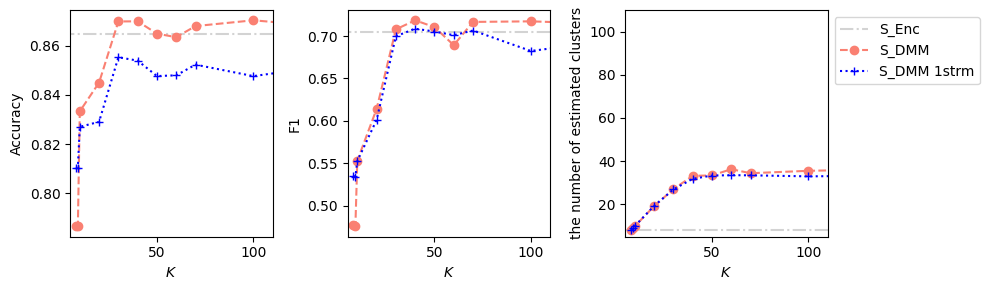

In [35]:
ks = [8,9,10,20,30,40,50,60,70,100,200]
data = [#N2enc_msds3_nemb_shuffle_Ens_cv64eqlE1V1Tx,
        N2enc_msds3_nemb_shuffle_Ens_cv64eqlT1V1Ex,
        #N2encT2_msds3_absFdfr10tfr060_clDMt1w1IB50allSeedOnly_cv64eqlE1V1TxMx,
        N2encT2_msds3_absFdfr10tfr060_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2,
        #N2encT2_FRT_absFdfr10tfr060_clDMt1w1IB50allSeedOnly_cv64eqlE1V1TxMx]#,
        N2encT2_FRT_absFdfr10tfr060_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2]
#labels = ['3strm $E_1V_1T_{62}$', '3strm $T_1V_1E_{62}$', '1strm $E_1V_1T_{62}$', '1strm $T_1V_1E_{62}$']
#labels = ['L_Enc', 'S_Enc', 'L_DMM 3s', 'S_DMM 3s', 'L_DMM 1s', 'S_DMM 1s']
labels = ['S_Enc', 'S_DMM', 'S_DMM 1strm']
colors = ['lightgray', 'salmon', 'b']
markers = [None, 'o', '+']
linestyles = ['-.', '--', ':']
fig = plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
st.showone(data, 'accuracy', None, labels, None, None, colors=colors, markers=markers, linestyles=linestyles, xlim=(5,110), ylim=None, ks=ks)
plt.ylabel('Accuracy')
plt.xlabel('$K$')
plt.subplot(1,3,2)
st.showone(data, 'F1', None, labels, None, None, colors=colors, markers=markers, linestyles=linestyles, xlim=(5,110), ylim=None, ks=ks)
plt.ylabel('F1')
plt.xlabel('$K$')
plt.subplot(1,3,3)
st.showone(data, 'topics', None, labels, None, None, colors=colors, markers=markers, linestyles=linestyles, xlim=(5,110), ylim=(5,110), ks=ks)
plt.ylabel('the number of estimated clusters')
plt.xlabel('$K$')
plt.legend(frameon=True, bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [95]:
fig.savefig('S_DMM_streams_rpdcbl.eps', format="eps")
fig.savefig('S_DMM_streams_rpdcbl.svg', format="svg")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## Sensitivity to TFRs

In [36]:
# TFR020
N2encT2_msds3_absFdfr10tfr020_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2 = st.read_results('01052EvalDMM2_epara_allseed_t1w1_T1V1ExM2.x.out.stat.txt') 
N2encT2_msds3_absFdfr10tfr020_clDMt1w1IB50allSeedOnly_cv64eqlE1V1TxMx = st.read_results('0105XEvalDMM2_epara_allseed_t1w1_E1V1TxMx.x.out.stat.txt') 

# TFR030
N2encT2_msds3_absFdfr10tfr030_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2 = st.read_results('01042EvalDMM2_epara_allseed_t1w1_T1V1ExM2.x.out.stat.txt') 
N2encT2_msds3_absFdfr10tfr030_clDMt1w1IB50allSeedOnly_cv64eqlE1V1TxMx = st.read_results('0104XEvalDMM2_epara_allseed_t1w1_E1V1TxMx.x.out.stat.txt') 

# TFR040
N2encT2_msds3_absFdfr10tfr040_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2 = st.read_results('01032EvalDMM2_epara_allseed_t1w1_T1V1ExM2.x.out.stat.txt') 
N2encT2_msds3_absFdfr10tfr040_clDMt1w1IB50allSeedOnly_cv64eqlE1V1TxMx = st.read_results('0103XEvalDMM2_epara_allseed_t1w1_E1V1TxMx.x.out.stat.txt') 

# TFR050
N2encT2_msds3_absFdfr10tfr050_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2 = st.read_results('01022EvalDMM2_epara_allseed_t1w1_T1V1ExM2.x.out.stat.txt') 
N2encT2_msds3_absFdfr10tfr050_clDMt1w1IB50allSeedOnly_cv64eqlE1V1TxMx = st.read_results('0102XEvalDMM2_epara_allseed_t1w1_E1V1TxMx.x.out.stat.txt') 

# TFR070
N2encT2_msds3_absFdfr10tfr070_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2 = st.read_results('01012EvalDMM2_epara_allseed_t1w1_T1V1ExM2.x.out.stat.txt') 
N2encT2_msds3_absFdfr10tfr070_clDMt1w1IB50allSeedOnly_cv64eqlE1V1TxMx = st.read_results('0101XEvalDMM2_epara_allseed_t1w1_E1V1TxMx.x.out.stat.txt') 


### large labeled data setting $E_1 V_1 T_{62}$

In [37]:
data = [N2encT2_msds3_absFdfr10tfr020_clDMt1w1IB50allSeedOnly_cv64eqlE1V1TxMx, 
        N2encT2_msds3_absFdfr10tfr030_clDMt1w1IB50allSeedOnly_cv64eqlE1V1TxMx, 
        N2encT2_msds3_absFdfr10tfr040_clDMt1w1IB50allSeedOnly_cv64eqlE1V1TxMx, 
        N2encT2_msds3_absFdfr10tfr050_clDMt1w1IB50allSeedOnly_cv64eqlE1V1TxMx, 
        N2encT2_msds3_absFdfr10tfr070_clDMt1w1IB50allSeedOnly_cv64eqlE1V1TxMx]
show_scores(data, ['DMM, 1stream, TFR0.2, E1V1T62 M63', 
                   'DMM, 1stream, TFR0.3, E1V1T62 M63', 
                   'DMM, 1stream, TFR0.4, E1V1T62 M63', 
                   'DMM, 1stream, TFR0.5, E1V1T62 M63', 
                   'DMM, 1stream, TFR0.7, E1V1T62 M63'])

DMM, 1stream, TFR0.2, E1V1T62 M63
K	ACC	ACCstd	F1	F1std	
008	0.783	0.019	0.456	0.007	
009	0.804	0.036	0.509	0.032	
010	0.772	0.020	0.402	0.033	
011	0.803	0.025	0.487	0.044	
012	0.802	0.025	0.487	0.045	
013	0.799	0.025	0.486	0.043	
014	0.810	0.034	0.513	0.035	
015	0.799	0.025	0.486	0.043	
016	0.826	0.016	0.531	0.020	
017	0.826	0.016	0.530	0.021	
018	0.810	0.022	0.540	0.046	
019	0.837	0.015	0.587	0.034	
020	0.832	0.015	0.537	0.020	
021	0.841	0.015	0.591	0.033	
022	0.841	0.015	0.591	0.033	
023	0.848	0.019	0.613	0.030	
024	0.877	0.019	0.697	0.041	
025	0.839	0.015	0.589	0.033	
026	0.866	0.022	0.672	0.041	
027	0.865	0.024	0.677	0.043	
028	0.864	0.021	0.668	0.042	
029	0.874	0.017	0.691	0.037	
030	0.872	0.019	0.686	0.039	
031	0.883	0.018	0.715	0.038	
032	0.858	0.020	0.670	0.043	
033	0.874	0.021	0.700	0.038	
034	0.877	0.020	0.703	0.038	
035	0.875	0.018	0.693	0.039	
036	0.884	0.020	0.718	0.036	
037	0.879	0.020	0.708	0.035	
038	0.884	0.019	0.719	0.038	
039	0.874	0.019	0.683	0.043	
040	0.878	0.018

### small labeled data setting $T_1 V_1 E_{62}$

In [38]:
data = [N2encT2_msds3_absFdfr10tfr020_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2, 
        N2encT2_msds3_absFdfr10tfr030_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2, 
        N2encT2_msds3_absFdfr10tfr040_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2, 
        N2encT2_msds3_absFdfr10tfr050_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2, 
        N2encT2_msds3_absFdfr10tfr070_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2]
show_scores(data, ['DMM, 3stream, TFR0.2, T1V1E62 M2', 
                   'DMM, 3stream, TFR0.3, T1V1E62 M2', 
                   'DMM, 3stream, TFR0.4, T1V1E62 M2', 
                   'DMM, 3stream, TFR0.5, T1V1E62 M2', 
                   'DMM, 3stream, TFR0.7, T1V1E62 M2'])

DMM, 3stream, TFR0.2, T1V1E62 M2
K	ACC	ACCstd	F1	F1std	
008	0.782	0.004	0.459	0.010	
009	0.778	0.040	0.511	0.012	
010	0.767	0.006	0.416	0.018	
011	0.789	0.010	0.474	0.023	
012	0.786	0.013	0.475	0.023	
013	0.782	0.014	0.475	0.022	
014	0.800	0.013	0.517	0.014	
015	0.775	0.018	0.471	0.023	
016	0.803	0.017	0.520	0.018	
017	0.800	0.018	0.516	0.018	
018	0.787	0.019	0.517	0.030	
019	0.813	0.019	0.574	0.025	
020	0.801	0.024	0.525	0.018	
021	0.815	0.019	0.577	0.028	
022	0.814	0.018	0.576	0.026	
023	0.819	0.019	0.587	0.026	
024	0.855	0.017	0.674	0.026	
025	0.806	0.020	0.575	0.028	
026	0.841	0.023	0.626	0.040	
027	0.843	0.019	0.639	0.037	
028	0.836	0.023	0.630	0.041	
029	0.848	0.019	0.666	0.027	
030	0.842	0.019	0.656	0.027	
031	0.856	0.014	0.692	0.018	
032	0.830	0.015	0.643	0.027	
033	0.845	0.015	0.673	0.025	
034	0.849	0.015	0.672	0.022	
035	0.846	0.015	0.663	0.027	
036	0.852	0.017	0.691	0.025	
037	0.851	0.016	0.681	0.024	
038	0.855	0.015	0.689	0.020	
039	0.843	0.019	0.668	0.022	
040	0.848	0.017	

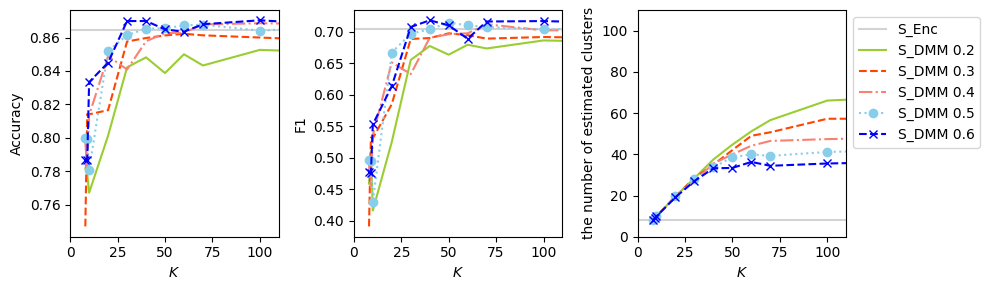

In [39]:
ks = [8,9,10,20,30,40,50,60,70,100,200]
data = [#N2enc_msds3_nemb_shuffle_Ens_cv64eqlE1V1Tx,
        N2enc_msds3_nemb_shuffle_Ens_cv64eqlT1V1Ex,
        N2encT2_msds3_absFdfr10tfr020_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2,
        N2encT2_msds3_absFdfr10tfr030_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2,
        N2encT2_msds3_absFdfr10tfr040_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2,
        N2encT2_msds3_absFdfr10tfr050_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2,
        N2encT2_msds3_absFdfr10tfr060_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2]
#        N2encT2_msds3_absFdfr10tfr070_clDMt1w1IB50allSeedOnly_cv64eqlT1V1ExM2]
labels = ['S_Enc', 'S_DMM 0.2', 'S_DMM 0.3', 'S_DMM 0.4', 'S_DMM 0.5', 'S_DMM 0.6']
colors = ['lightgray', 'yellowgreen', 'orangered', 'salmon', 'skyblue', 'b']
markers = [None, None, None, None, 'o', 'x']
linestyles = ['-', '-', '--', '-.', ':', '--']
fig = plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
st.showone(data, 'accuracy', None, labels, None, None, colors=colors, markers=markers, linestyles=linestyles, xlim=(0,110), ylim=None, ks=ks)
plt.ylabel('Accuracy')
plt.xlabel('$K$')
plt.subplot(1,3,2)
st.showone(data, 'F1', None, labels, None, None, colors=colors, markers=markers, linestyles=linestyles, xlim=(0,110), ylim=None, ks=ks)
plt.ylabel('F1')
plt.xlabel('$K$')
plt.subplot(1,3,3)
st.showone(data, 'topics', None, labels, None, None, colors=colors, markers=markers, linestyles=linestyles, xlim=(0,110), ylim=(0,110), ks=ks)
plt.ylabel('the number of estimated clusters')
plt.xlabel('$K$')
plt.legend(frameon=True, bbox_to_anchor=(1, 1), loc='upper left')
#plt.legend(frameon=False, bbox_to_anchor=(0, 1), loc='upper left')
#plt.legend(frameon=False, bbox_to_anchor=(1, 0), loc='lower right')
plt.tight_layout()
plt.show()

In [99]:
fig.savefig('S_DMM_tfr_rpdcbl.eps', format="eps")
fig.savefig('S_DMM_tfr_rpdcbl.svg', format="svg")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
